# Trabajo Práctico 2 AAII 2025 - Redes Recurrentes y Reinforcement Learning



PROBLEMA 1 -GRUPO N° 5

Autores:

- Herrera Morena (H-1187/8)

- Nardi Gianella Belén (N-1277/7)

- Zorzolo Rubio Juana (Z-1217/3)

Objetivo: construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


## Importaciones

In [ ]:
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import tensorflow_datasets as tfds
from IPython.display import Audio, display as ipy_display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga de datos

In [ ]:
# Cargar el dataset con división 80% train y 20% validación
(df_train, df_val), df_info = tfds.load('spoken_digit', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

In [ ]:
# Obtener nombres de clases
label_names = np.array(df_info.features["label"].names)
print("Clases disponibles:", label_names)

# Mostrar cantidad real de ejemplos en cada subset
print("Ejemplos en df_train:", tf.data.experimental.cardinality(df_train).numpy())
print("Ejemplos en df_val:",   tf.data.experimental.cardinality(df_val).numpy())

# Mostrar ejemplos de df_train
for audio, label in df_train.take(3):
    print(f"Label: {label.numpy()} ({label_names[label.numpy()]})")
    print(f"Forma del audio: {audio.shape}")

Clases disponibles: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Ejemplos en df_train: 2000
Ejemplos en df_val: 500
Label: 2 (2)
Forma del audio: (1525,)
Label: 1 (1)
Forma del audio: (2929,)
Label: 9 (9)
Forma del audio: (6457,)


## Preprocesamiento y Análisis de datos (EDA)

In [ ]:
# recorremos los audios y creamos un DataFrame con su información

audios = []
labels = []

for audio, label in df_train:
    audios.append(audio.numpy())
    labels.append(label.numpy())

data = []

for audio, label in df_train:
    arr = audio.numpy()
    data.append({
        'clase': label.numpy(),
        'duracion_muestras': len(arr),
        'media': np.mean(arr),
        'std': np.std(arr),
        'max': np.max(arr),
        'min': np.min(arr)
    })

df = pd.DataFrame(data)

In [ ]:
df.head()

,clase,duracion_muestras,media,std,max,min
0,2,1525,-225.447869,1056.924425,2560,-3072
1,1,2929,-248.396040,1555.141301,5376,-8448
2,9,6457,-0.236952,369.355777,1468,-1119
3,9,3360,-1.070536,340.482869,1264,-2111
4,7,2746,-232.786599,1588.794435,7680,-7936


Datos obtenidos hasta ahora:


*   hay 9 clases disponibles
*   hay 2000 datos de train y 500 de validación
*   duración de las muestras de audio
*   mín y max son métricas del array de numpy para ese audio




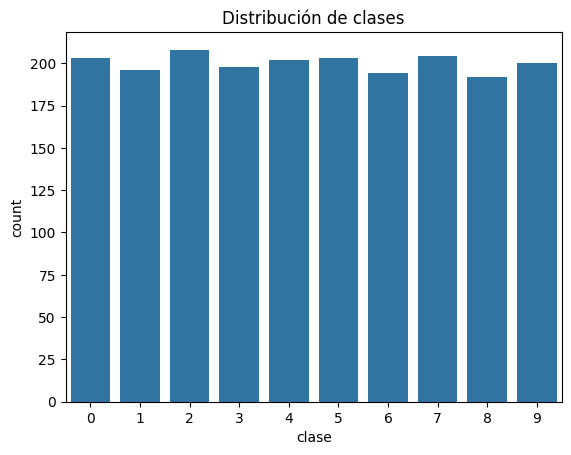

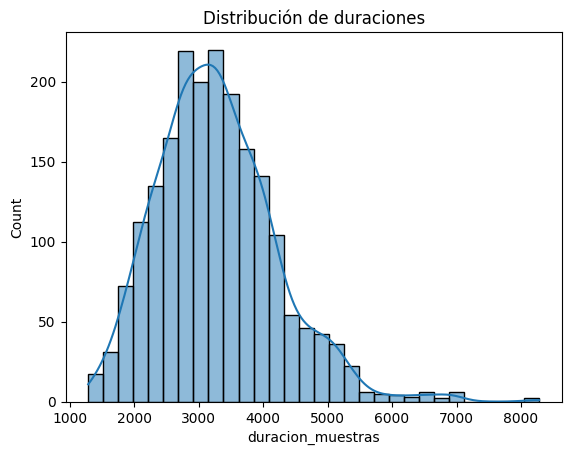

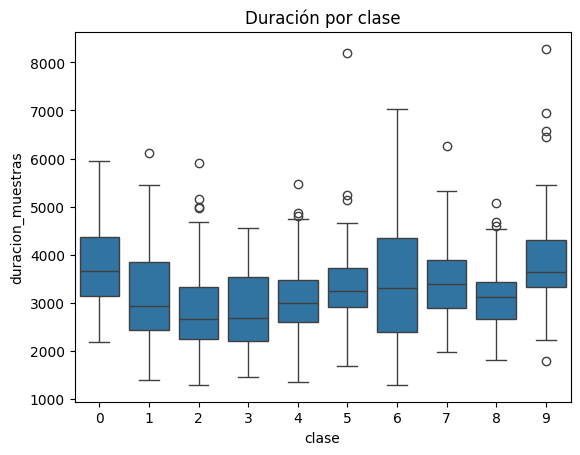

In [ ]:
# Distribución de clases
sns.countplot(x='clase', data=df)
plt.title("Distribución de clases")
plt.show()

# Distribución de duración
sns.histplot(df['duracion_muestras'], bins=30, kde=True)
plt.title("Distribución de duraciones")
plt.show()

# Boxplot por clase
sns.boxplot(x='clase', y='duracion_muestras', data=df)
plt.title("Duración por clase")
plt.show()


Conclusión:

Distribución de clases (Gráfico 1):

Muestra una distribución balanceada de las clases. Confirmamos que no hay gran desbalance en la cantidad de muestras por clase por lo cual no es necesario aplicar técnicas de balanceo.

Distribución de duraciones (Gráfico 2):

Podemos observar la distribución general de la duración de los audios. Vemos que la distribución se asemeja a una normal con una asimetría positiva (cola hacia la derecha).

Boxplot por clase (Gráfico 3):

Nos permite ver la mediana, los cuartiles y los posibles outliers de duración por cada dígito. Observamos la presencia de outliers y cierta variabilidad en la duración de los clips, lo cual nos indica la necesidad de implementar un preprocesamiento antes de entrenar el modelo.


In [ ]:
# Mostrar y reproducir los primeros 3 audios
for i, (audio, label) in enumerate(df_train.take(3)):
    print(f"Ejemplo {i+1} - Dígito: {label.numpy()}")
    ipy_display(Audio(audio.numpy(), rate=16000))  # Asumimos sample rate de 16kHz

Ejemplo 1 - Dígito: 2


Ejemplo 2 - Dígito: 1


Ejemplo 3 - Dígito: 9


In [ ]:
# Mostrar y reproducir los primeros 3 audios
for i, (audio, label) in enumerate(df_val.take(3)):
    print(f"Ejemplo {i+1} - Dígito: {label.numpy()}")
    ipy_display(Audio(audio.numpy(), rate=16000))  # Asumimos sample rate de 16kHz

Ejemplo 1 - Dígito: 6


Ejemplo 2 - Dígito: 8


Ejemplo 3 - Dígito: 4


## Squeeze
Para normalizar y llevar todos los audios a 8000hz

In [ ]:
LONG_HZ = 8000  # 1 segundo a 8kHz

def squeeze(audio, label):
    """
    Normaliza la señal de audio, elimina dimensiones extra y ajusta su longitud a LONG_HZ.
    - Convierte a float32 en [-1, 1]
    - Quita cualquier dimensión extra (como [N,1] -> [N])
    - Si el audio es más corto, hace padding con ceros.
    - Si es más largo, lo recorta a LONG_HZ.
    """
    # 1) Convertir a float32 y normalizar
    audio = tf.cast(audio, tf.float32) / 32768.0

    # 2) Asegurar forma 1D
    audio = tf.reshape(audio, [-1])  # más robusto que tf.squeeze

    # 3) Ajustar la longitud
    audio_len = tf.shape(audio)[0]
    audio = tf.cond(
        audio_len < LONG_HZ,
        lambda: tf.pad(audio, [[0, LONG_HZ - audio_len]]),
        lambda: audio[:LONG_HZ]
    )

    return audio, label

In [ ]:
df_train = df_train.map(squeeze, num_parallel_calls=AUTOTUNE)
df_val = df_val.map(squeeze, num_parallel_calls=AUTOTUNE)

In [ ]:
for audio, label in df_train.take(1):
    print("Forma del audio:", audio.shape)  # (8000,)
    print("Etiqueta:", label.numpy())

Forma del audio: (8000,)
Etiqueta: 2


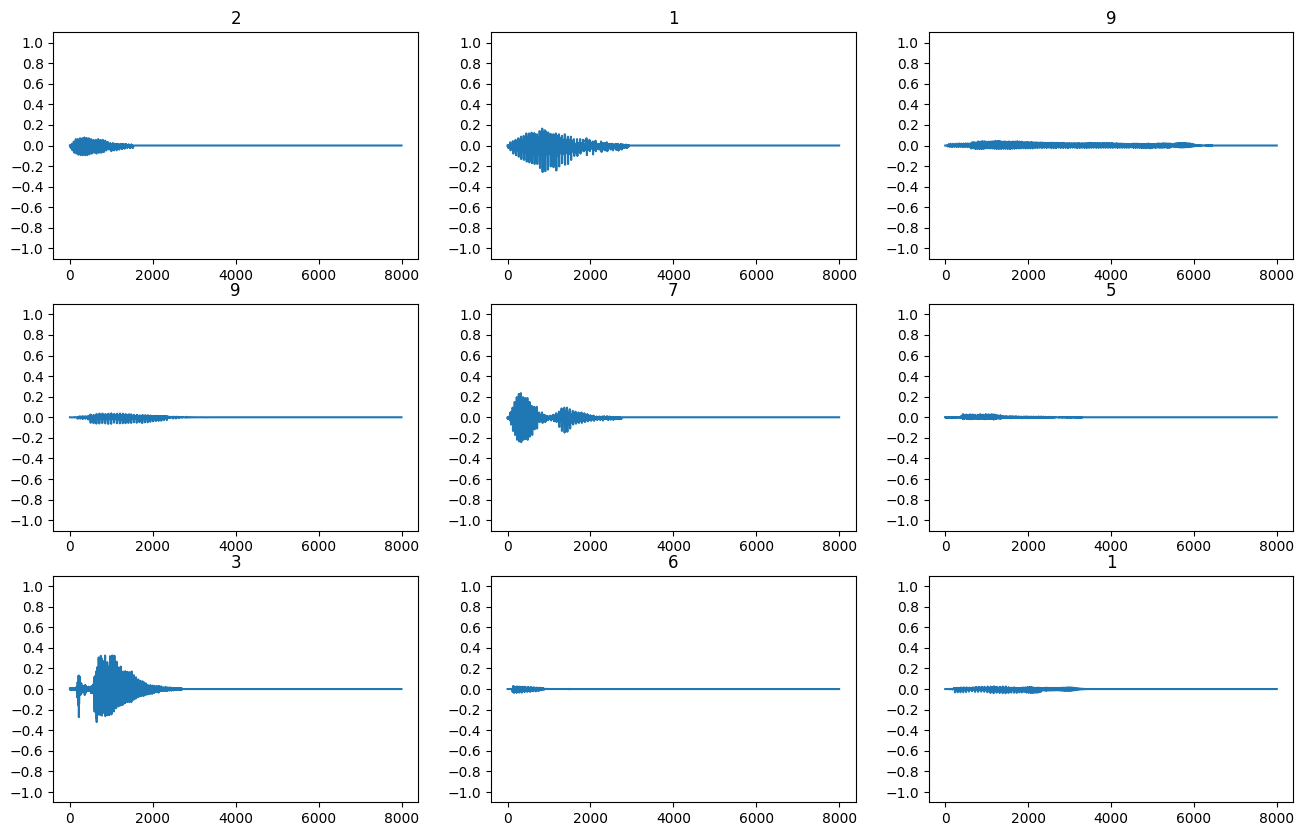

In [ ]:
# plotear forma de onda para algunos ejemplos

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

audios = []
labels = []

for audio, label in df_train.take(n):
    audios.append(audio.numpy())
    labels.append(label.numpy())

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(audios[i])
    plt.title(label_names[labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.show()

## Convertir a espectogramas para modelo convolucional

se transforman las formas de onda de **señales del dominio del tiempo** a **señales del dominio tiempo-frecuencia** al calcular la transformada de Fourier de corto tiempo (STFT) para convertir las formas de onda en espectrogramas, que muestran cambios de frecuencia a lo largo del tiempo y pueden ser representados como imágenes 2D.

In [ ]:
def get_spectrogram(waveform):
  # Convierte la forma de onda en espectograma mediante STFT
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtiene la maginitud de STFT
  spectrogram = tf.abs(spectrogram)
  # agrega un canal a la dimensión para que el espectograma se pueda usar
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # logaritmo para mejor visualización
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='gouraud')

In [ ]:
# Tomar 3 ejemplos del dataset procesado (normalizado y con longitud 8000)
example_audios = []
example_labels = []
for audio, label in df_train.take(3):
    example_audios.append(audio)
    example_labels.append(label.numpy())

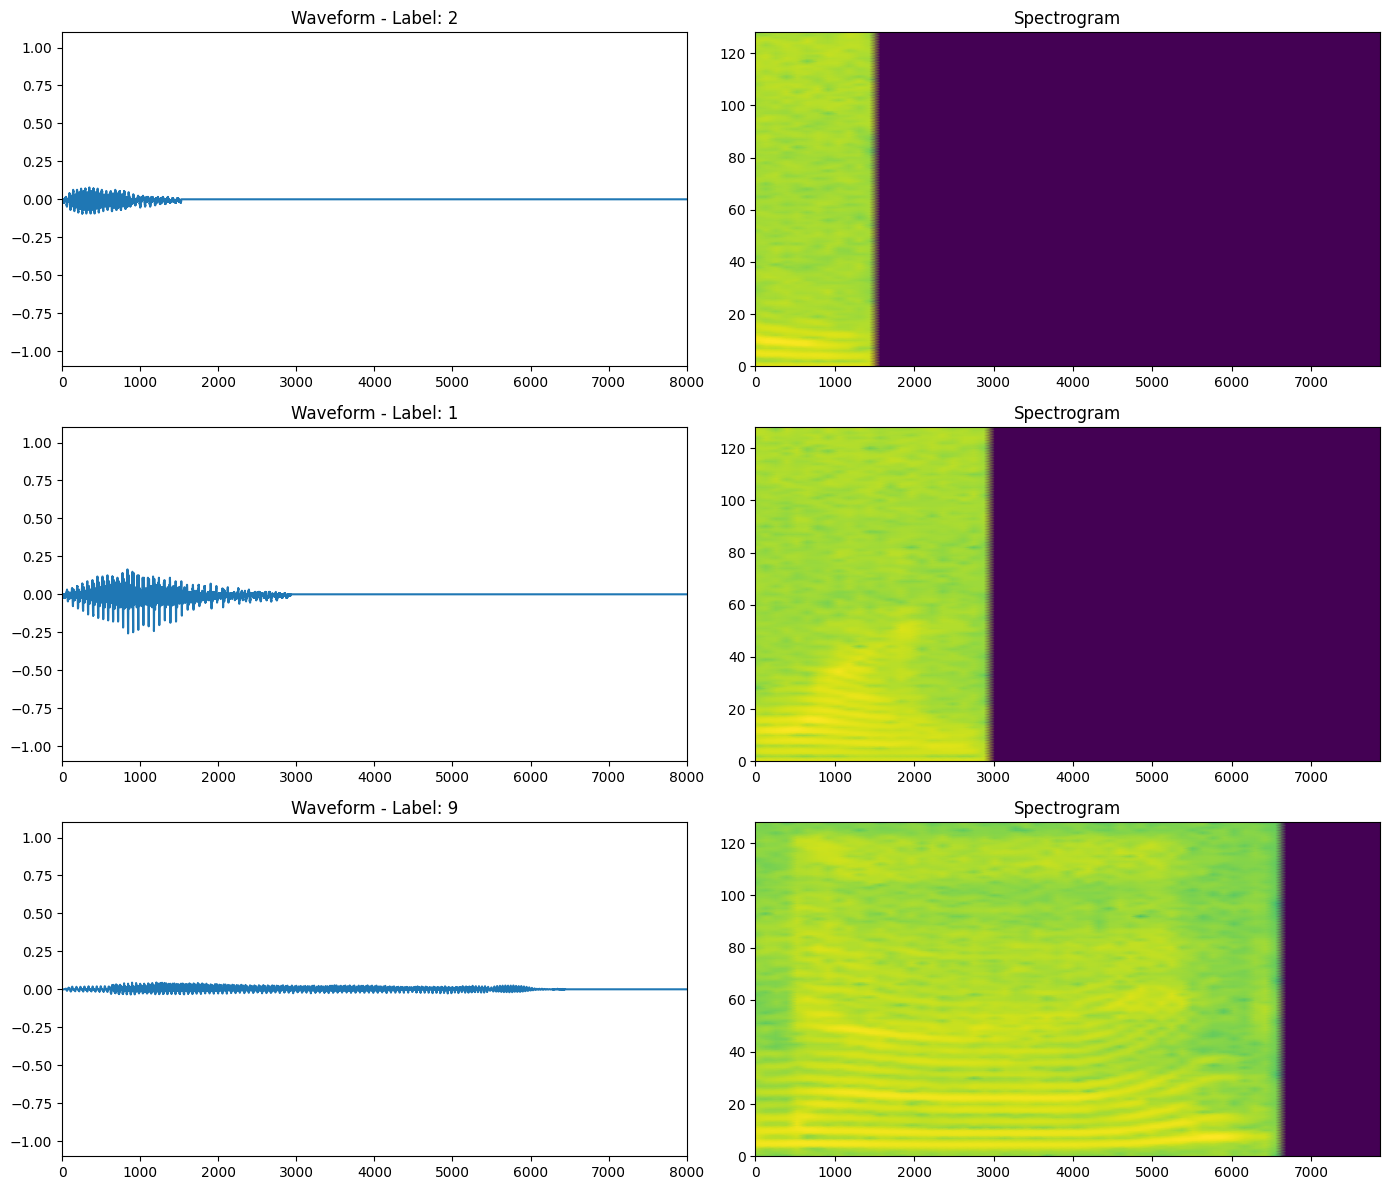

In [ ]:
# Visualización
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i in range(3):
    waveform = example_audios[i]
    label = label_names[example_labels[i]]
    spectrogram = get_spectrogram(waveform)

    # Forma de onda
    timescale = np.arange(waveform.shape[0])
    axes[i, 0].plot(timescale, waveform.numpy())
    axes[i, 0].set_title(f'Waveform - Label: {label}')
    axes[i, 0].set_xlim([0, LONG_HZ])
    axes[i, 0].set_ylim([-1.1, 1.1])

    # Espectrograma
    plot_spectrogram(spectrogram.numpy(), axes[i, 1])
    axes[i, 1].set_title('Spectrogram')

    # Audio playback (solo del primer ejemplo para no saturar)
    if i == 0:
        ipy_display(display.Audio(waveform.numpy(), rate=LONG_HZ))

plt.tight_layout()
plt.show()

## Crear datasets con los espectogramas

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 16
train_spectrogram_ds = make_spec_ds(df_train).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_spectrogram_ds = make_spec_ds(df_val).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
# Examinar espectogramas para los distintos ejemplos del dataset
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

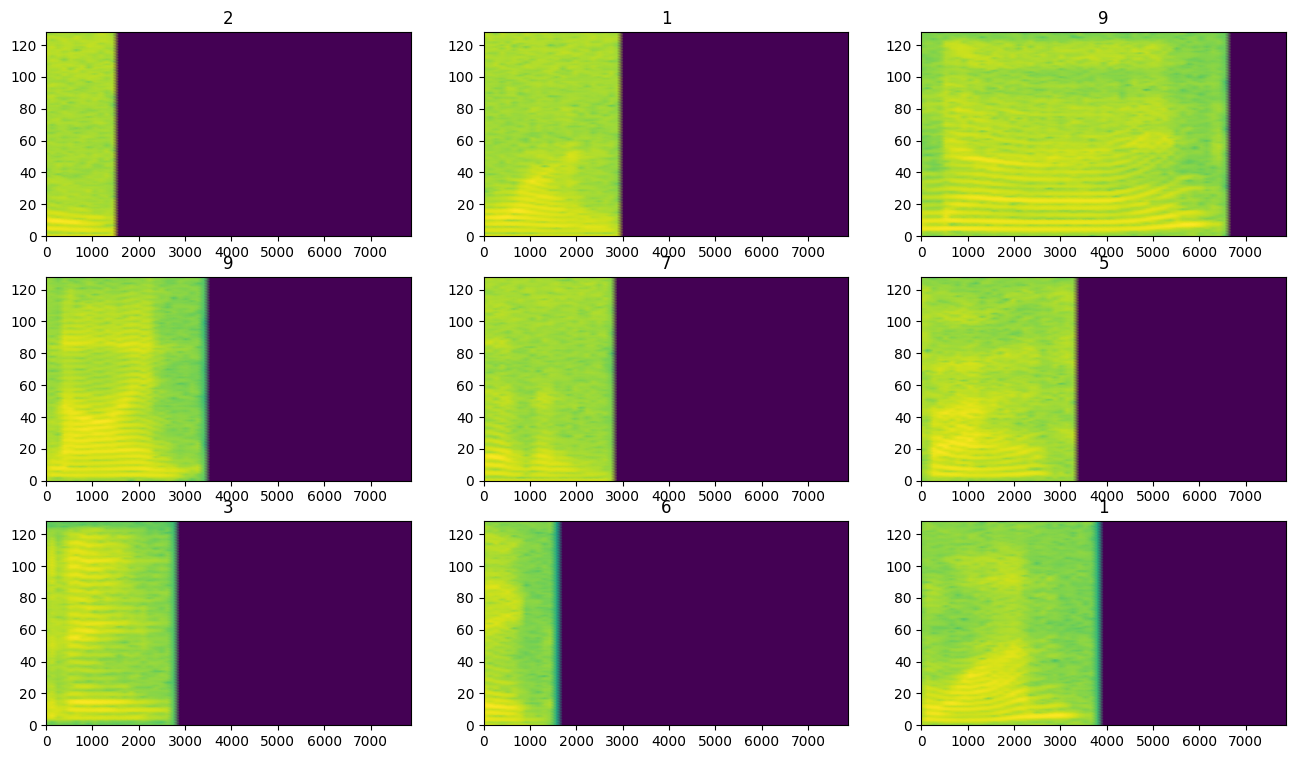

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

## Modelo convolucional

TRABAJA CON IMÁGENES 2D (ESPECTOGRAMAS)

### Optimizar la carga del dataset

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### Definición del modelo

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation = 'softmax'),
])
model.summary()

Input shape: (61, 129, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_8 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False ya que softmax está en el modelo
    metrics=['accuracy'],
)

### Entrenamiento

In [ ]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.2982 - loss: 1.9938 - val_accuracy: 0.6700 - val_loss: 1.1146
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6618 - loss: 1.0721 - val_accuracy: 0.8180 - val_loss: 0.7089
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.7824 - loss: 0.6899 - val_accuracy: 0.8780 - val_loss: 0.4596
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8549 - loss: 0.5013 - val_accuracy: 0.9020 - val_loss: 0.3378
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8717 - loss: 0.4240 - val_accuracy: 0.9080 - val_loss: 0.3092
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9206 - loss: 0.2779 - val_accuracy: 0.9320 - val_loss: 0.2406
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9317 - loss: 0.2327 - val_accuracy: 0.9340 - val_loss: 0.2350
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.9317 - loss: 0.2277 - val

### Evaluación

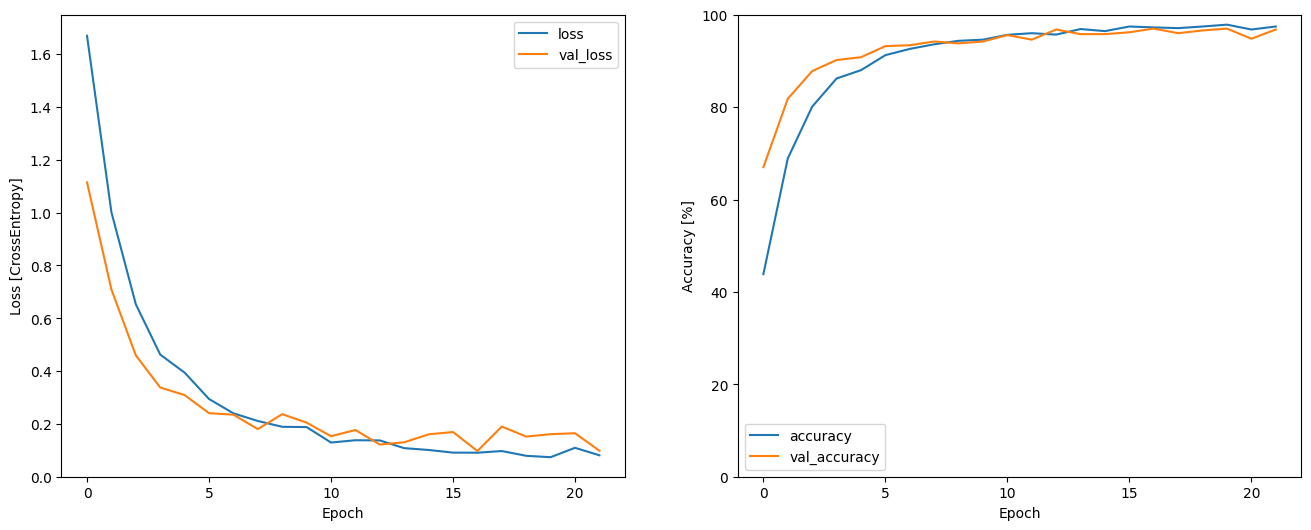

In [ ]:
# Visualización
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

Las curvas de validación son similares a las de entrenamiento, lo que demuestra que el modelo generaliza bien tanto en train como en test. La precisión converge y se maniene prácticamente estable a partir de la época 10, con un valor cercano al 98%.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


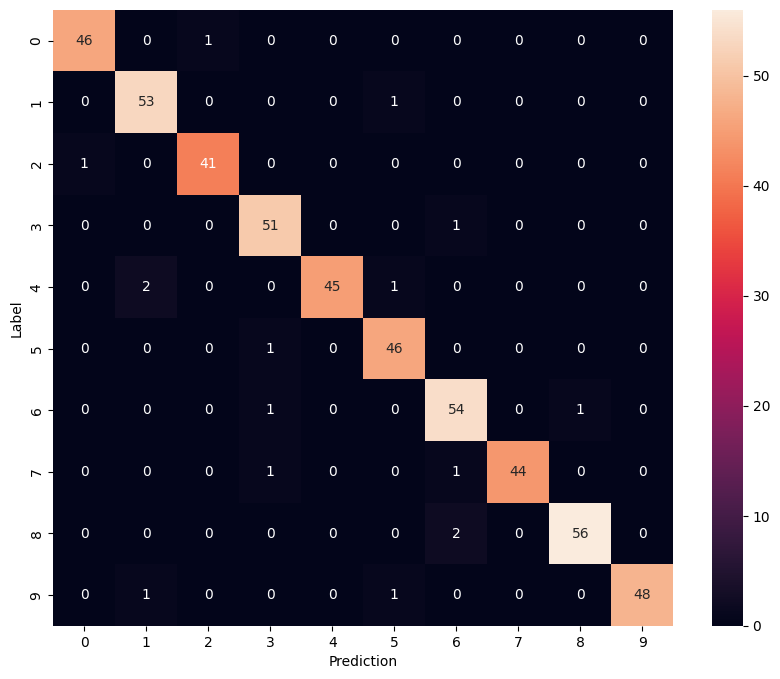

In [ ]:
# matriz de confusión para veificar qué tan bien clasificó el modelo
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

La matriz de consufión muestra que el modelo es altamente preciso, ya que la mayoría de las predicciones están ubicadas en la diagonal y solo hay algunos errores poco frecuentes y dispersos.


### Inferir sobre un archivo de audio

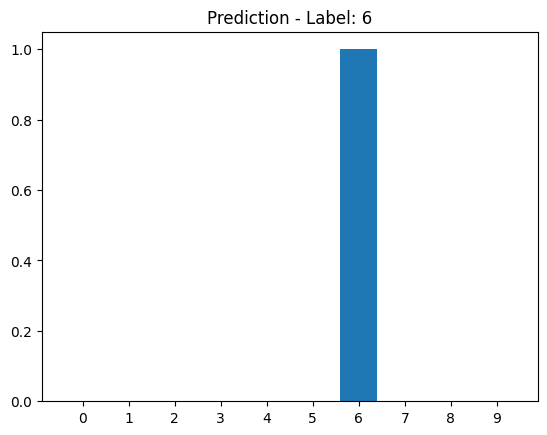

Etiqueta real: 6


In [ ]:
def predecir_y_escuchar(dataset, index=0):
  for i, (waveform, label) in enumerate(dataset.skip(index).take(1)):
    spectrogram = get_spectrogram(waveform)
    spectrogram = spectrogram[tf.newaxis, ...]
    prediction = model(spectrogram)

    x_labels = label_names
    plt.bar(x_labels, prediction[0]) # quitar el softmax
    plt.title(f'Prediction - Label: {label_names[label.numpy()]}')
    plt.show()

    display.display(display.Audio(waveform, rate=16000))
    print(f'Etiqueta real: {label_names[label.numpy()]}')

predecir_y_escuchar(df_val, index=9)

Conclusión: El modelo convolucional demostró un muy buen desempeńo al clasificar los dígitos a partir de audios. El preprocesamiento de los datos contribuyó a la mejoría del rendimiento del modelo, el cual alcanzó una alta precisión rápidamente sin sobreajustarse.

## Modelo recurrente

### Preparación del dataset

Sacamos el canal que no es necesario para este modelo

In [ ]:
def remove_channel(spectrogram, label):
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # quita el canal de tamaño 1
    return spectrogram, label

In [ ]:
train_rnn = train_spectrogram_ds.map(remove_channel)
val_rnn = val_spectrogram_ds.map(remove_channel)

In [ ]:
# Revisar la forma de un batch
for batch_x, batch_y in train_rnn.take(1):
    print(batch_x.shape)  # (BATCH_SIZE, timesteps, features)

(16, 61, 129)


### Optimizar la carga del Dataset

In [ ]:
train_rnn = train_rnn.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_rnn = val_rnn.cache().prefetch(tf.data.AUTOTUNE)

### Definición del modelo

In [ ]:
# Normalización
batch_specs = []
for spec, _ in train_rnn.take(100):  # spec shape: (batch_size, timesteps, features)
    batch_specs.append(spec.numpy())
batch_specs = np.concatenate(batch_specs, axis=0)  # concatena todos los batchs en una sola dimensión de samples

norm_layer = layers.Normalization()
norm_layer.adapt(batch_specs)

# Input shape
example_spectrograms = next(iter(train_rnn.take(1)))[0]  # (batch_size, timesteps, features)
input_shape_rnn = example_spectrograms.shape[1:]        # (timesteps, features)

# Modelo
rnn_model = models.Sequential([
    layers.Input(shape=input_shape_rnn),
    norm_layer,
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_labels, activation = 'softmax'),
])

In [ ]:
# Compilación
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Entrenamiento

In [ ]:
# Entrenamiento
EPOCHS = 50
history_rnn = rnn_model.fit(
    train_rnn,
    validation_data=val_rnn,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.1005 - loss: 2.3165 - val_accuracy: 0.0920 - val_loss: 2.3076
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.0880 - loss: 2.3067 - val_accuracy: 0.0840 - val_loss: 2.3078
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.0948 - loss: 2.3036 - val_accuracy: 0.0960 - val_loss: 2.3026
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1013 - loss: 2.3026 - val_accuracy: 0.1180 - val_loss: 2.2929
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.1144 - loss: 2.2879 - val_accuracy: 0.1260 - val_loss: 2.2534
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.1467 - loss: 2.2269 - val_accuracy: 0.0980 - val_loss: 2.2013
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1517 - loss: 2.2165 - val_accuracy: 0.1520 - val_loss: 2.1617
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1749 - loss: 2.1447 - val_a

### Evaluación

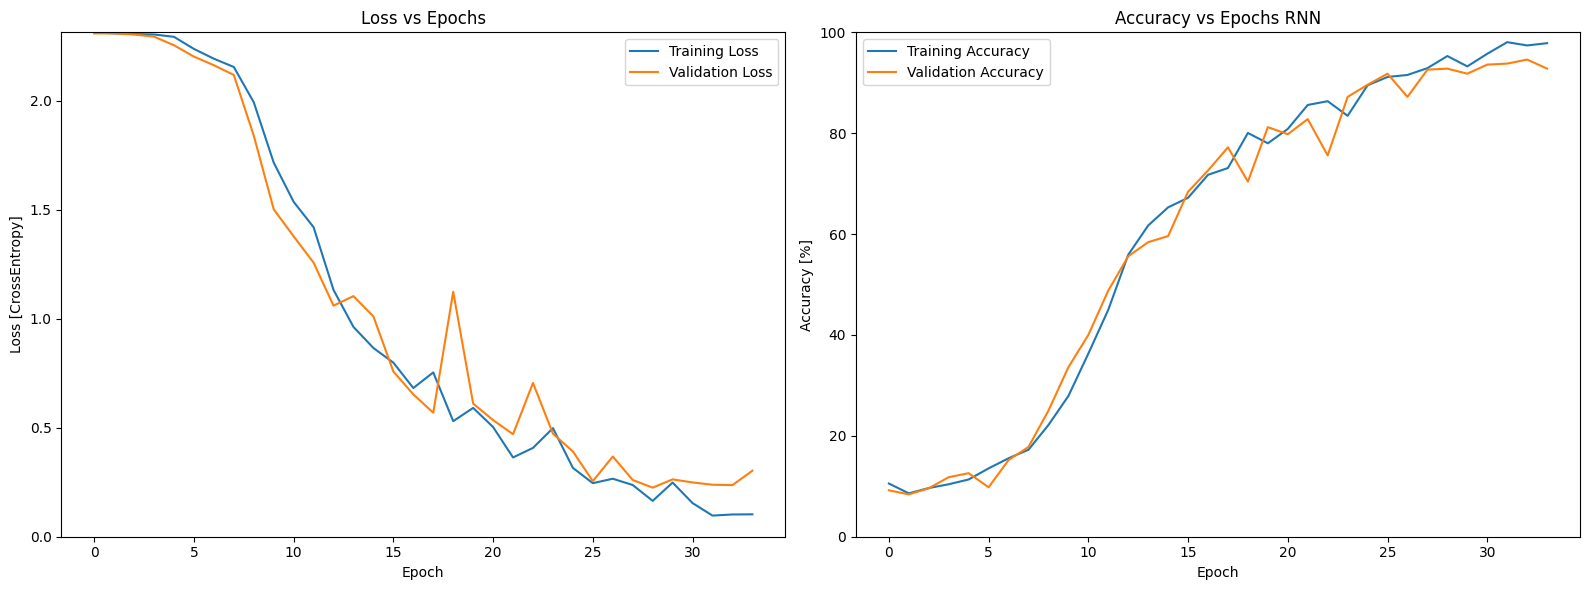

In [ ]:
# Evaluación
metrics = history_rnn.history

plt.figure(figsize=(16, 6))

# Gráfico de pérdida (loss)
plt.subplot(1, 2, 1)
plt.plot(history_rnn.epoch, metrics['loss'], label='Training Loss')
plt.plot(history_rnn.epoch, metrics['val_loss'], label='Validation Loss')
plt.legend()
plt.ylim([0, max(max(metrics['loss']), max(metrics['val_loss']))])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Loss vs Epochs')

# Gráfico de precisión (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_rnn.epoch, 100 * np.array(metrics['accuracy']), label='Training Accuracy')
plt.plot(history_rnn.epoch, 100 * np.array(metrics['val_accuracy']), label='Validation Accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy vs Epochs RNN')

plt.tight_layout()
plt.show()

La pérdida de validación varía notablemente, lo que sugiere cierta sensibilidad al conjunto de validación. La precisión en validación varía, aunque más levemente, entre las mismas épocas. Sin embargo, el modelo logra una muy alta precisión y una disminución progresiva de la pérdida.



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


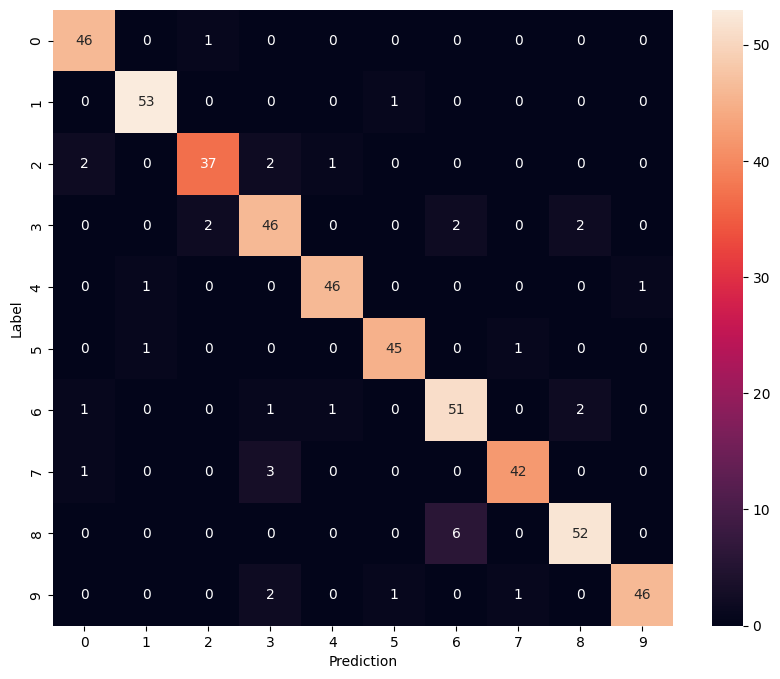

In [ ]:
# Confusion matrix
y_pred_rnn = rnn_model.predict(val_rnn)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)
y_true_rnn = tf.concat(list(val_rnn.map(lambda s, lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

La matriz de confusión nos demuestra que el modelo predice mayormente bien, con mínimos errores dispersos. Observamos que confunde la clase '6' con la clase '8'.

### Inferir sobre un archivo de audio

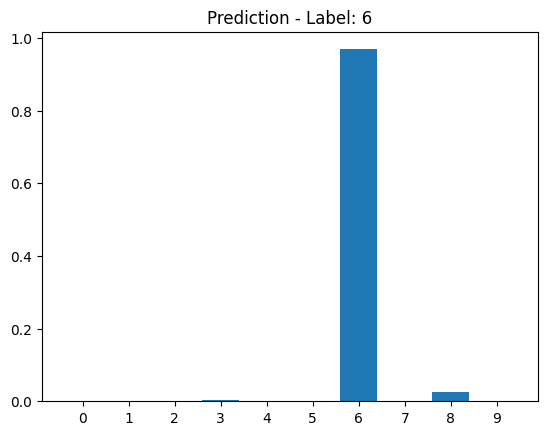

Etiqueta real: 6


In [ ]:
def predecir_y_escuchar(dataset, model, index=0):
  for i, (waveform, label) in enumerate(dataset.skip(index).take(1)):
    spectrogram = get_spectrogram(waveform)
    spectrogram = spectrogram[tf.newaxis, ...]
    prediction = model(spectrogram)

    x_labels = label_names
    plt.bar(x_labels, prediction[0])
    plt.title(f'Prediction - Label: {label_names[label.numpy()]}')
    plt.show()

    display.display(display.Audio(waveform, rate=16000))
    print(f'Etiqueta real: {label_names[label.numpy()]}')

predecir_y_escuchar(df_val, rnn_model, index=0)

Conclusión: Construimos dos modelos de clasificación de dígitos a partir de clips de audio, utilizando técnicas de aprendizaje profundo.

Se entrenaron y evaluaron dos modelos:



*   Una Red Neuronal Convolucional (CNN), que logró una precisión de validación del 97% con curvas estables y una matriz de confusión limpia, evidenciando gran capacidad de generalización.
*   Una Red Neuronal Recurrente (RNN), que alcanzó también una precisión elevada, aunque mostró mayor inestabilidad durante el entrenamiento y errores más dispersos en la clasificación final.

Ambos modelos demostraron ser capaces de abordar con éxito la tarea, pero el modelo convolucional se destacó por su mayor precisión, estabilidad y robustez. Esto sugiere que, en este caso, el uso de representaciones espaciales del audio (como espectrogramas) se adapta mejor a arquitecturas convolucionales que a recurrentes.

En resumen, se logró el objetivo del trabajo con una solución precisa, generalizable y robusta, incluyendo prácticas de preprocesamiento, entrenamiento y evaluación.



